# Example 03. Process a LEAF time-series

This example generates a Plant Area Volume Density (PAVD) profile time-series.

## Load all the required modules

In [1]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib

from pylidar_canopy import leaf_io, plant_profile

## Some plotting functions

In [2]:
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout() 
    plt.show()

    
def plot_xyz(x, y, z, c, figsize=[8,8], elev=None, azim=None, cmap='viridis'):
    """Example function to plot the LEAF point cloud""" 
    fig = plt.figure(figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax = fig.add_subplot(projection='3d')
        ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])
        ax.scatter(x, y, z, c=c, s=3, cmap=cmap)
        ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
        ax.view_init(elev, azim)
    fig.tight_layout()
    plt.show()    

    
def plot_timseries_2d(data, clim=[0,0.2], title=None, nbins='auto', cmap='gist_earth', 
              label=r'PAVD ($m^{2} m^{-3}$)', facecolor='0.5', extend='max', extent=None, figsize=(20,10)):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.set_facecolor(facecolor)
        ax.set(adjustable='datalim', xlabel='Date', ylabel='Height (m)')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        if title is not None:
            ax.set_title(title)

        p = ax.imshow(data, interpolation='nearest', clim=clim, cmap=cmap, 
                      alpha=1.0, vmin=clim[0], vmax=clim[1], extent=extent, aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=nbins))
        
    fig.tight_layout()
    plt.show()

    
def plot_timseries_1d(dates, values, xlim=[None,None], ylim=[0,None], title=None, 
              label=r'PAI ($m^{2} m^{-2}$)', figsize=(20,10)):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.plot_date(dates, values, linestyle='dashed', color='DarkGreen')
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        ax.set(xlabel='Date', ylabel=label)
    fig.autofmt_xdate() 
    plt.tight_layout()
    plt.show()

## Identify all of the input files

Create a list of all files available to generate a time-series.

In [54]:
sensor = 363

os.chdir(f'/gpfs/data1/vclgp/data/leaf/01Nov22/{sensor:d}')

# Data files
hemi_csv_list = glob.glob('data/ESS?????_*_hemi_*.csv')
hinge_csv_list = glob.glob('data/ESS?????_*_hinge_*.csv')
ground_csv_list = glob.glob('data/ESS?????_*_ground_*.csv')

# Power files
power_csv_list = glob.glob('pwr/ESS?????_pwr_*.csv')

In [55]:
with leaf_io.LeafScanFile(hinge_csv_list[0], sensor_height=1.5) as f:
    df = f.data
df.head()

,sample_count,scan_encoder,rotary_encoder,range1,intensity1,range2,sample_time,target_count,datetime,zenith,azimuth,x1,y1,z1,h1,x2,y2,z2,h2
0,0,6575.0,0,9.76,100,9.77,26.03,2,2022-10-29 03:15:28.026030,1.008334,5.951228,-2.690721,7.805669,5.204725,6.704725,-2.693478,7.813666,5.210057,6.710057
1,1,6575.0,3,9.72,100,9.64,25.02,2,2022-10-29 03:15:28.051050,1.008334,5.952170,-2.672365,7.776200,5.183394,6.683394,-2.650371,7.712199,5.140732,6.640732
2,2,6575.0,5,9.61,100,9.59,25.06,2,2022-10-29 03:15:28.076110,1.008334,5.952798,-2.637291,7.689857,5.124734,6.624734,-2.631803,7.673853,5.114069,6.614069
3,3,6575.0,8,9.57,100,9.55,24.66,2,2022-10-29 03:15:28.100770,1.008334,5.953741,-2.619096,7.660321,5.103403,6.603403,-2.613622,7.644312,5.092738,6.592738
4,4,6575.0,12,9.51,100,9.49,25.65,2,2022-10-29 03:15:28.126420,1.008334,5.954998,-2.593107,7.615558,5.071407,6.571407,-2.587654,7.599542,5.060741,6.560741


## Visualize the 3D point cloud

Let's check the hinge angle scan is where we think it is

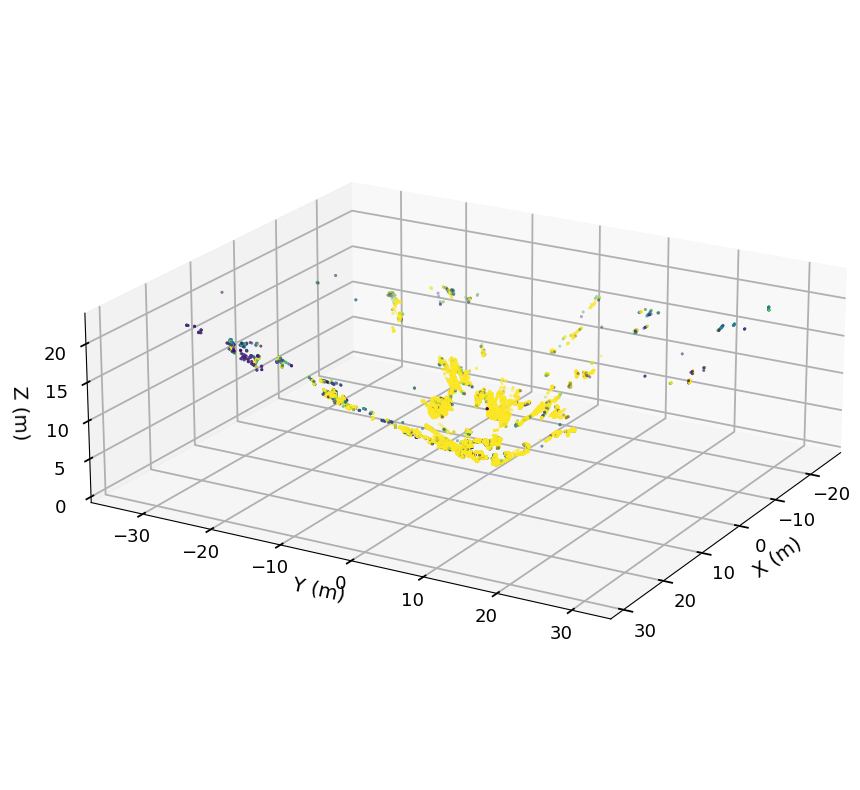

In [56]:
valid = ~(np.isnan(df.x1) | np.isnan(df.y1) | np.isnan(df.z1))
plot_xyz(df.x1[valid], df.y1[valid], df.z1[valid], df.intensity1[valid], 
         figsize=[8,8], elev=20, azim=30, cmap='viridis')

## Generate $P_{gap}$ and PAVD profiles for a single hemi scan

Plot the $P_{gap}$ and PAVD profiles for an example scan. Note that no quality filtering has taken place yet.

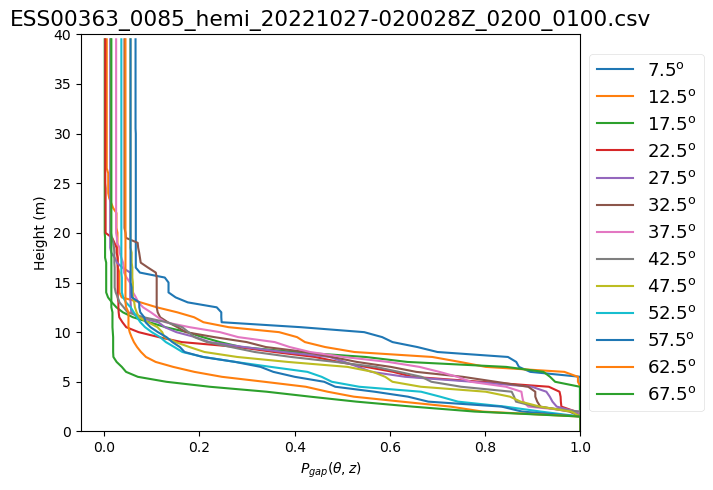

In [57]:
leaf_file = hemi_csv_list[0]
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=40)
valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', min_zenith=5, max_zenith=70, sensor_height=1.5)
if valid:
    vpp.get_pgap_theta_z()
    title = os.path.basename(leaf_file)
    pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
    plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                           labels=pgap_labels, ylim=[0,40], xlim=[None,1], figsize=[7,5], title=title)

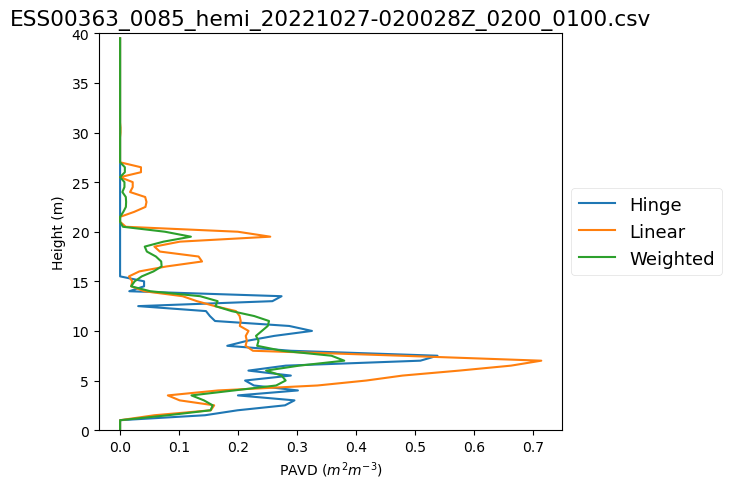

In [58]:
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=40)
valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', min_zenith=5, max_zenith=70, sensor_height=1.5)
if valid:
    vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)

    hinge_pai = vpp.calcHingePlantProfiles()
    weighted_pai = vpp.calcSolidAnglePlantProfiles()
    linear_pai,linear_mla = vpp.calcLinearPlantProfiles()

    hinge_pavd = vpp.get_pavd(hinge_pai)
    linear_pavd = vpp.get_pavd(linear_pai)
    weighted_pavd = vpp.get_pavd(weighted_pai)      
    
    title = os.path.basename(leaf_file)
    plot_vertical_profiles([hinge_pavd,linear_pavd,weighted_pavd], vpp.height_bin, 
        labels=['Hinge','Linear','Weighted'], ylim=[0,40], figsize=[7,5], title=title)

## Plot the PAVD time-series

In [59]:
hres = 0.5
max_h = 40

ncols = len(hemi_csv_list)
nrows = int(max_h / hres)
pavd_grid = np.full((nrows,ncols), -9999, dtype=float)

In [60]:
leaf_dates = []
leaf_pai = []
leaf_files = sorted(hemi_csv_list)

for i,leaf_file in enumerate(leaf_files):
    vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=360, min_z=5, max_z=70, min_h=0, max_h=max_h)
    valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', min_zenith=5, max_zenith=70, sensor_height=1.5)
    if valid:
        vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
        pai = vpp.calcSolidAnglePlantProfiles()
        pavd_grid[:,i] = vpp.get_pavd(pai)
        leaf_pai.append(pai[-1])
        leaf_dates.append(vpp.datetime)


In [61]:
extent = [mdates.date2num(leaf_dates[0]),mdates.date2num(leaf_dates[-1]),0,max_h] 
pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

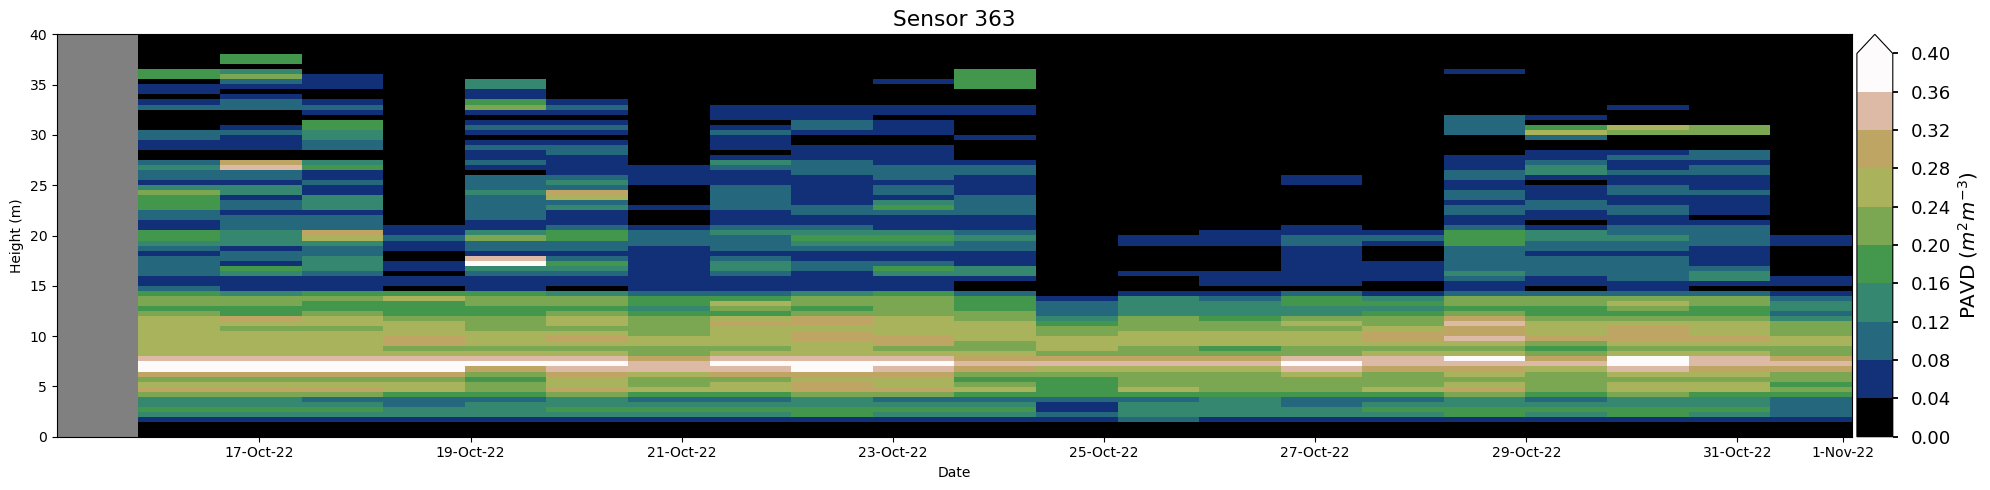

In [67]:
plot_timseries_2d(pavd_grid[::-1], clim=[0,0.4], title=f'Sensor {sensor:d}', nbins=10, cmap=matplotlib.cm.get_cmap('gist_earth',10), 
                  label=r'PAVD ($m^{2} m^{-3}$)', facecolor='0.5', extend='max', extent=extent, figsize=(20,5))

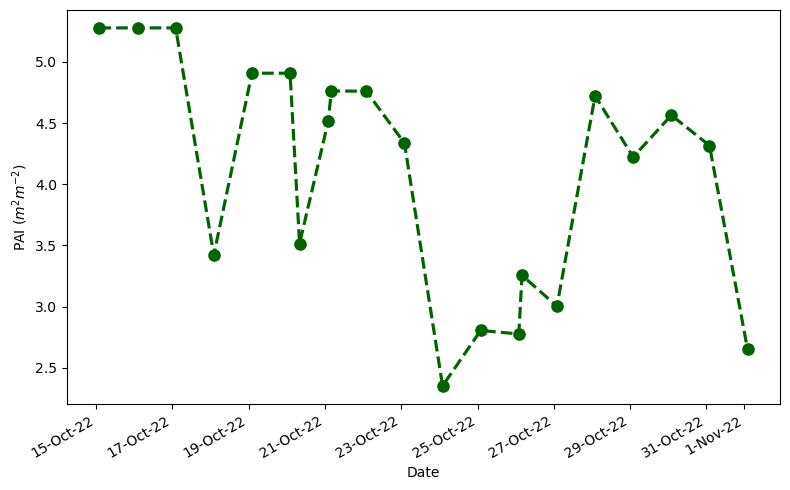

In [63]:
plot_timseries_1d(leaf_dates, leaf_pai, xlim=[None,None], ylim=[0,None], title=None, 
                  label=r'PAI ($m^{2} m^{-2}$)', figsize=(8,5))